# Introduction
This notebook contains a working example to show usage of the image perturbation and classifier-based saliency map generation API.

This example will follow an application-like use-case where we define a functionally rigid process that transforms an input image into a number of saliency heat-maps based on our black-box classifier's output, visualizing them over the input image.
We will show that it is easy to change which of our API implementations are used in the application without impacting the application's successful execution, first using a sliding-window perterbation algorithm and then using the RISE perturbation algorithm.

This will necessarily include the use of a classification model to perform the role of the black-box classifier that we will be determining the saliency for.
We will fill this role here with a PyTorch Imagenet-pretrained ResNet18 network.

### Table of Contents
* [The test image](#The-test-image)
* [The "application"](#The-"application")
* [Black-box Classifier](#Black-box-Classifier)
* [XAI Components](#XAI-Components)
* [Calling the Application](#Calling-the-Application)

### Additional Python Requirements
The following additional python packages are required for this notebook besides the usual depedencies for `xaitk-saliency`:
- jupyter
- torch (tested with 1.9.0)
- torchvision  (tested with 0.10.0)

### Miscellaneous
*Note*: When using the `from_config_dict` method below,
it is not unusual for the below code to throwback a warning
indicating missing psycopg2 and caffe modules.
Please disregard any such warnings.

Reference for implementation: Zeiler MD, Fergus R. Visualizing 
and understanding convolutional networks. InEuropean conference
on computer vision 2014 Sep 6 (pp. 818-833). Springer, Cham.

License for test image used may be found in 'COCO-LICENSE.txt'.

# The test image
We will test this application on the following image.
We know that this image contains the ImageNet classes of "boxer" and "tiger cat".

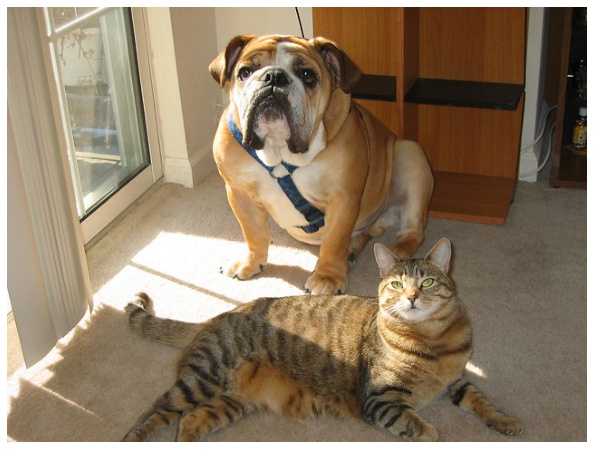

In [1]:
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request


# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', "catdog.jpg")
test_image_filename = 'catdog.jpg'
plt.figure(figsize=(12, 8))
plt.axis('off')
_ = plt.imshow(PIL.Image.open(test_image_filename))

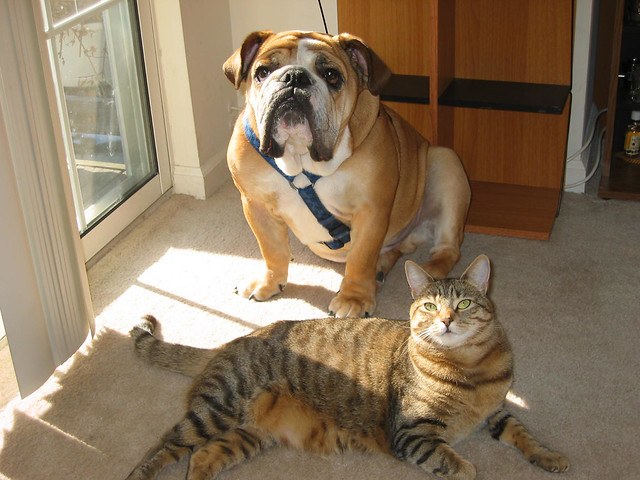

In [2]:
import PIL.Image
import urllib.request

urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', "catdog.jpg")
test_image_filename = 'catdog.jpg'
PIL.Image.open(test_image_filename)

# The "application"
First we will set up our application as a function with defined inputs for
  * the image
  * black-box classifier
  * image perturbation API implementation
  * saliency map generation API implementation

For the purposes of this tool, let's say that the input blackbox classifier must take in one image (as a numpy matrix) and output a 1D vector of per-class confidences (`Callable[[np.ndarray], np.ndarray]`) for simplicity.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from typing import Callable, Optional, Sequence, Union
from xaitk_saliency import PerturbImage, GenerateClassifierConfidenceSaliency
from xaitk_saliency.utils.masking import occlude_image_batch


def app(
    image_filepath: str,
    # Assuming outputs `nClass` length arrays.
    blackbox_classify: Callable[[np.ndarray], np.ndarray],
    perturber: PerturbImage,
    sal_map_generator: GenerateClassifierConfidenceSaliency,
    fill: Optional[Union[int, Sequence[int]]] = None,
    vis_mask_examples: bool = True,
):
    # Load the image
    ref_image = np.asarray(PIL.Image.open(image_filepath))
    # Use the perterbation API implementation input to generate a bunch of images.
    # We will use the outputs here multiple times later so we will just aggregate
    # the output here.
    pert_masks = perturber(ref_image)
    print(f"Perterbation masks: {pert_masks.shape}")
    
    pert_imgs = occlude_image_batch(ref_image, pert_masks, fill)
    print(f"Perterbed images: {pert_imgs.shape[0]}")

    # Visualize some example perturbed images before heading into blackbox classification
    if vis_mask_examples:
        n = 4
        print(f"Visualizing {n} random perturbed images...")
        rng = np.random.default_rng(seed=0)
        rng_idx_lst = sorted(rng.integers(0, len(pert_masks)-1, n))
        plt.figure(figsize=(n*4, 3))
        for i, rnd_i in enumerate(rng_idx_lst):
            plt.subplot(1, n, i+1)
            plt.title(f"pert_imgs[{rnd_i}]")
            plt.axis('off')
            plt.imshow(pert_imgs[rnd_i])

    # For the saliency heatmap generation API we need reference image predictions as well as
    # the predictions for each of the perturbed images.
    ref_preds = blackbox_classify(ref_image)
    print(f"Ref preds: {ref_preds.shape}")
    pert_preds = np.asarray([
        blackbox_classify(pi)
        for pi in pert_imgs
    ])

    print(f"Pert preds: {pert_preds.shape}")
    sal_maps = sal_map_generator(ref_preds, pert_preds, pert_masks)
    print(f"Saliency maps: {sal_maps.shape}")
        
    # Visualize the saliency heat-maps
    plot_saliency_maps(ref_image, sal_maps, alpha_blend=False)
        
    return pert_masks, ref_preds, pert_preds, sal_maps


def plot_saliency_maps(ref_image, sal_maps, alpha_blend=True, clim=True):
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046*(ref_image.shape[0]/ref_image.shape[1]),
        "pad": 0.04,
    }
    hm_alpha = 0.3 if alpha_blend else 1.0
    for i, class_sal_map in enumerate(sal_maps):
        print(f"Class {i} saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 2+i)
        if alpha_blend:
            plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, 0, 1),
            cmap='jet',
            alpha=hm_alpha
        )
        if clim:
            plt.clim(0, 1)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Pos Saliency")
        plt.axis('off')

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind+2+i)
        if alpha_blend:
            plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, -1, 0),
            cmap='jet_r',
            alpha=hm_alpha
        )
        if clim:
            plt.clim(-1, 0)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Neg Saliency")
        plt.axis('off')

# Black-box Classifier
In this example we will use a basic PyTorch-based pretrained ResNet18 model and use it's softmax output as classification confidences.
Since this model normally outputs 1000 classes, we will, for simplicity of example, constrain the output to the two classes that we happen to know are relevant for our test image
* "boxer"
* "tiger cat"

In [4]:
# Set up our "black box" classifier using PyTorch and it's ImageNet pretrained ResNet18.
# We will constrain the output of our classifier here to the two classes that are relevant
# to our test image for the purposes of this example.
import os
import PIL.Image
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms

CUDA_AVAILABLE = torch.cuda.is_available()


model = models.resnet18(pretrained=True)
model = model.eval()
if CUDA_AVAILABLE:
    model = model.cuda()

# These are some simple helper functions to perform prediction with this model
model_input_size = (224, 224)
model_mean = [0.485, 0.456, 0.406]
model_loader = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(model_input_size), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=model_mean,
        std=[0.229, 0.224, 0.225]
    ),
])


# Grabbing the class labels associated with this model.
if not os.path.isfile('imagenet_classes.txt'):
    !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

f = open("imagenet_classes.txt", "r")
categories = [s.strip() for s in f.readlines()]


# For this test, we will use an image with both a cat and a dog in it.
# Let's only consider the saliency of two class predictions.
sal_class_labels = ['boxer', 'tiger cat']
sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]


def blackbox_topk(test_image: PIL.Image.Image, k=1):
    image_tensor = model_loader(test_image).unsqueeze(0)
    if CUDA_AVAILABLE:
        image_tensor = image_tensor.cuda()
    feature_vec = model(image_tensor)
    return categories[
        torch.topk(
            feature_vec.cpu().detach(),
            k=1,
        ).indices.squeeze()
    ]


def blackbox_classifier(test_image: np.ndarray) -> np.ndarray:
    image_tensor = model_loader(test_image).unsqueeze(0)
    if CUDA_AVAILABLE:
        image_tensor = image_tensor.cuda()
    feature_vec = model(image_tensor)
    # Converting feature extractor output to probabilities.
    class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()
    # Only return the confidences for the focus classes
    return class_conf[sal_class_idxs]

blackbox_fill = np.uint8(np.asarray(model_mean) * 255)

# XAI Components
Here we will setup our XAI components comprised of image perturbation and classifier-based saliency map generation.

We will start with the sliding-window perturbation method and the occlusion-based saliency map generation method.

We additionally construct a second perturber, RISE, that we will use in a second invocation of the "application" to show that it still functions successfully due to API consistency, but with different results as per using a different algorithm.

In [5]:
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindow
from xaitk_saliency.impls.perturb_image.rise import RISEGrid
from xaitk_saliency.impls.gen_classifier_conf_sal.occlusion_scoring import OcclusionScoring
from xaitk_saliency.impls.gen_classifier_conf_sal.rise_scoring import RISEScoring

perturber_slidingwindow = SlidingWindow((50, 50), (20, 20))
# perturber_slidingwindow = SlidingWindow((320, 320), (20, 20))
perturber_rise = RISEGrid(1000, 8, 0.5, seed=0, threads=4)
# perturber_rise = RISEGrid(2000, 25, 0.99, seed=0, threads=4)

sal_map_generator = OcclusionScoring()  # Sliding window method
sal_map_generator_rise = RISEScoring()  # RISE method
sal_map_generator_debiased_rise = RISEScoring(p1=0.5)  # debiased RISE method


# Calling the Application
Here we will show that can invoke the same "application" (function) with different `xaitk-saliency` API interface implementations while still successfully executing, visualizing the different results that are generated.

## Sliding window perturbation + OcclusionScoring

Perterbation masks: (884, 480, 640)
Perterbed images: 884
Visualizing 4 random perturbed images...
Ref preds: (2,)


/home/local/KHQ/paul.tunison/.cache/pypoetry/virtualenvs/xaitk-saliency-b8zmqbMt-py3.8/lib64/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Pert preds: (884, 2)
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-1.0, 0.6352883840990408]
Class 1 saliency map range: [-1.0, 0.9723985898191845]


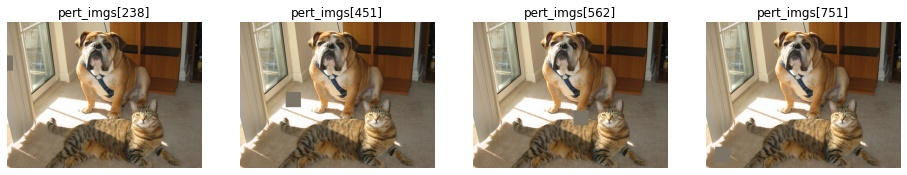

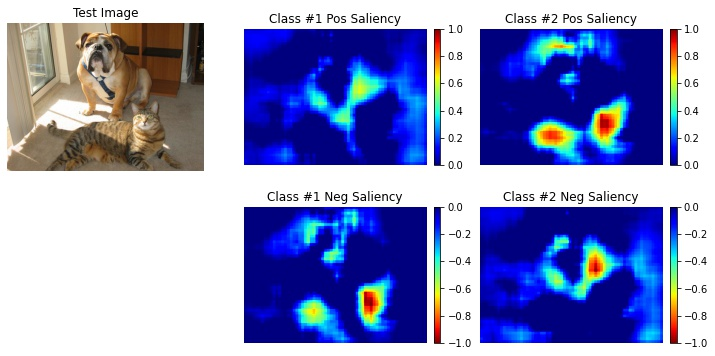

In [6]:
sal_maps = app(
    test_image_filename,
    blackbox_classifier,
    perturber_slidingwindow,
    sal_map_generator,
    fill=blackbox_fill,
)

## RISE perturbation + OcclusionScoring

Perterbation masks: (1000, 480, 640)
Perterbed images: 1000
Visualizing 4 random perturbed images...
Ref preds: (2,)
Pert preds: (1000, 2)
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [0.8023771643638611, 1.0]
Class 1 saliency map range: [-0.812501847743988, 1.0]


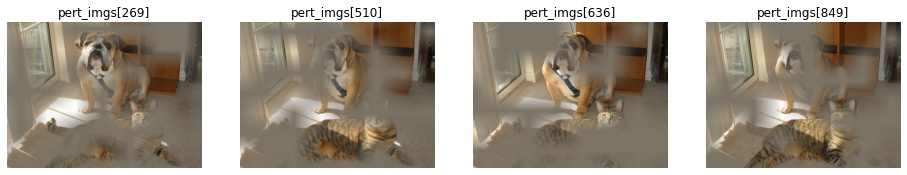

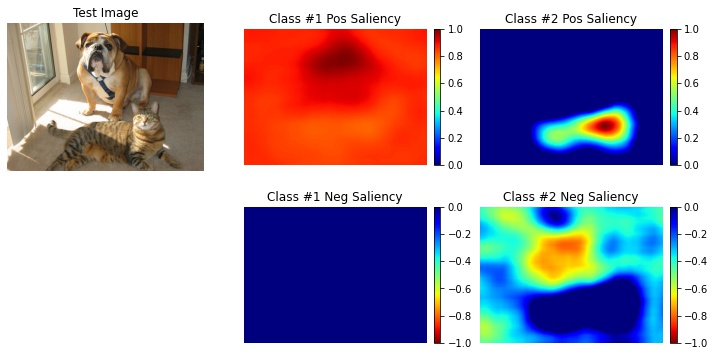

In [7]:
sal_maps = app(
    test_image_filename,
    blackbox_classifier,
    perturber_rise,  # The change
    sal_map_generator,
    fill=blackbox_fill,
)

## RISE perturbation + RISEScoring

Perterbation masks: (1000, 480, 640)
Perterbed images: 1000
Ref preds: (2,)
Pert preds: (1000, 2)
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [0.4051729738712311, 1.0]
Class 1 saliency map range: [0.6819127202033997, 1.0]


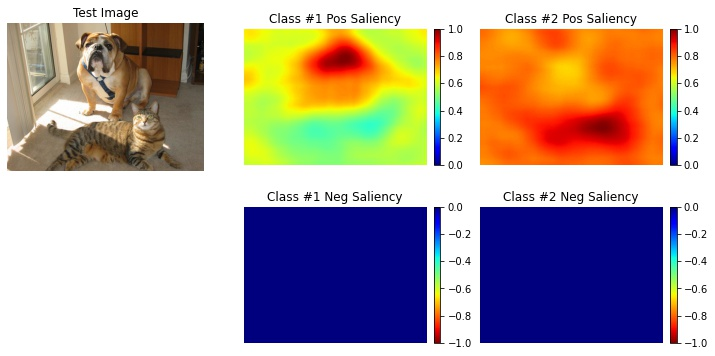

In [8]:
# pert_masks, ref_preds, pert_preds, sal_maps
masks_sw, ref_preds_sw, pert_preds_sw, maps_sw = app(
    test_image_filename,
    blackbox_classifier,
    perturber_rise,
    sal_map_generator_rise,  # The change
    fill=blackbox_fill,
    vis_mask_examples=False,
)

## RISE perturbation + DebiasedRISEScoring

Perterbation masks: (1000, 480, 640)
Perterbed images: 1000
Ref preds: (2,)
Pert preds: (1000, 2)
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-0.5133521556854248, 1.0]
Class 1 saliency map range: [-0.5018323063850403, 1.0]


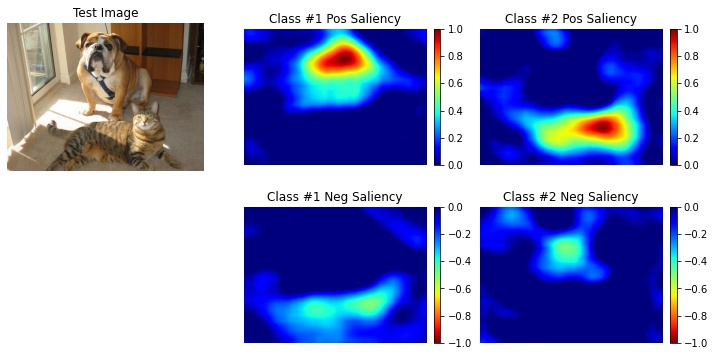

In [9]:
masks_rise, ref_preds_rise, pert_preds_rise, maps_rise = app(
    test_image_filename,
    blackbox_classifier,
    perturber_rise,
    sal_map_generator_debiased_rise,  # The change
    fill=blackbox_fill,
    vis_mask_examples=False,
)

In [10]:
# Sliding window alias'
ref_image = np.asarray(PIL.Image.open(test_image_filename))
masks = masks_sw
ref_preds = ref_preds_sw
pert_preds = pert_preds_sw
maps = maps_sw

In [11]:
# RISE alias'
ref_image = np.asarray(PIL.Image.open(test_image_filename))
masks = masks_rise
ref_preds = ref_preds_rise
pert_preds = pert_preds_rise
maps = maps_rise

mean 'unperturbed' pixels: 0.5012122988700867
ref preds
[0.2859901  0.35938922]
pert preds
[[3.2978700e-03 5.7873189e-01]
 [7.0048713e-06 8.7670159e-01]
 [3.9456546e-04 6.2769586e-01]
 ...
 [5.5169766e-03 5.4264426e-01]
 [2.1520136e-03 3.4707403e-01]
 [1.2768256e-02 3.5085642e-01]]
Diffs
[[ 0.28269222 -0.21934268]
 [ 0.2859831  -0.5173124 ]
 [ 0.28559554 -0.26830664]
 ...
 [ 0.2804731  -0.18325505]
 [ 0.28383806  0.01231518]
 [ 0.27322182  0.00853279]]
[-0.5432645  -0.61434984]
[0.28598997 0.35932347]
HM shape: (2, 480, 640)
Class 0 saliency map range: [0.8023771643638611, 1.0]
Class 1 saliency map range: [-0.812501847743988, 1.0]


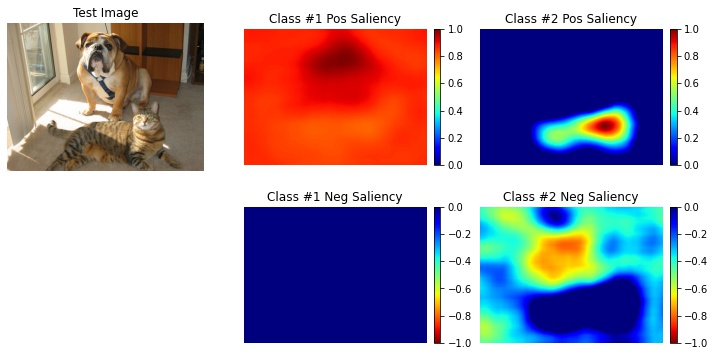

In [12]:
# LEARNING INTERPRETATION / ANALYSIS
#
# Looks like the SlidingWindow perturbation confidence difference histogram shows the majority of deltas are
# around 0, whereas the RISE perturbation confidence difference histogram shows the majorigy of deltas are 
# not. Are we missing a normalization term on the heatmap based on the accumulated delta?
# `diff[:,class].sum()/2` seems to adjust the heatmap values across the 0-point for this example, but is
# this just a made up heuristic?

print(f"mean 'unperturbed' pixels: {(masks.sum(axis=0) / len(masks)).mean()}")

print(f"ref preds\n{ref_preds}")
print(f"pert preds\n{pert_preds}")

### manual OcclusionScoring for tweasing.
# We want to determine how how much the masked region changed the prediction outcomes.
# We want to know the delta *from* the reference, which we interpret as being directly
#   caused by the removal of the masked pixcel information.
# "occlusion impact"
diff = ref_preds - pert_preds
# diff = pert_preds - ref_preds  # unoccluded impact
print("Diffs")
print(diff)
print(diff.min(axis=0))
print(diff.max(axis=0))

# Inverse used twice below
masks_inv = (np.uint8(1) - masks)

# Masks are defined where the values closer to 0 are "occluded", so need to invert masks
# so more masked regions are higher values for multiplying against "occlusion impact" diff.
# Transposing is to swap axes appropriately for broadcasting the multiply operation.
# (N,H,W) (T)=> (WxHxN) * (N,nClases) => (W,H,N,nClasses) (sum N axis [#2]) => (W,H,nClasses) (T)=> (nClasses,H,W)
# Should be dtype=float32 regardless of mask dtype at this point as elevated by preds diff dtype.
# *** A DIFF BETWEEN SW and RIST: (1 - masks) is int for SW and float for RISE.
# *** -> Doesn't matter in the end. See notes on classification result skews.                             
hm = (masks_inv.T[..., None] * diff).sum(axis=2).T
# hm = (masks.T[..., None] * diff).sum(axis=2).T  # unoccluded impact
print(f"HM shape: {hm.shape}")

hm_norm = hm / masks_inv.sum(axis=0)

from sklearn.preprocessing import maxabs_scale
hm_scaled = maxabs_scale(
#     hm.reshape(hm.shape[0], -1),
    hm_norm.reshape(hm.shape[0], -1),
    axis=1
).reshape(hm.shape)

plot_saliency_maps(ref_image,  hm_scaled, alpha_blend=False)
    

Before ranges:
	106.45809936523438 -- 136.32203674316406
	-33.099124908447266 -- 39.95125198364258
Adjustment: [-115.75025    13.599672]
After ranges:
	-9.292152404785156 -- 20.57178497314453
	-19.499452590942383 -- 53.550926208496094
scaled ranges:
	-0.47487151622772217 -- 1.0
	-0.3569829761981964 -- 1.0
Class 0 saliency map range: [-0.47487151622772217, 1.0]
Class 1 saliency map range: [-0.3569829761981964, 1.0]


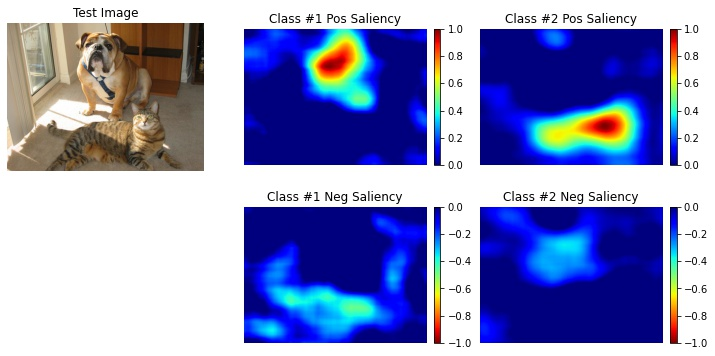

In [13]:
# "Heuristic" #1, heatmap adjustment value that is half the sum
print("Before ranges:")
[print(f"\t{hm_.min()} -- {hm_.max()}") for hm_ in hm]

adjust = -diff.sum(axis=0) / 2
print(f"Adjustment: {adjust}")

hm_h1 = (hm.T + adjust).T
print("After ranges:")
[print(f"\t{hm_.min()} -- {hm_.max()}") for hm_ in hm_h1]

# Normalize to mitigate gridding effect
masks_sum = masks_inv.sum(axis=0)
masks_sum[masks_sum == 0] = 1
hm_h1_norm = hm_h1 / masks_sum

hm_h1_scaled = maxabs_scale(
    hm_h1_norm.reshape(hm_h1.shape[0], -1),
    axis=1
).reshape(hm_h1.shape)
print("scaled ranges:")
[print(f"\t{hm_.min()} -- {hm_.max()}") for hm_ in hm_h1_scaled]

plot_saliency_maps(ref_image, hm_h1_scaled, alpha_blend=False)

# CONCLUSION:
# Looks like it separates semantically expected positive and negative regions.
# This however doesn't coincide with the bias in the evidence where there is overwhelming evidence in one
# side of the salient/not-salient measurements.

Pos/neg counts (class column-major):
[[934 488]
 [ 66 512]]
Pos/Neg gmean:
[248.28209762 499.85597926]
gmean weights for diff:
[[0.26582666 1.02429504]
 [3.76184996 0.97628121]]
Before ranges:
	[0] 106.45809936523438 :: 136.32203674316406
	[1] -33.099124908447266 :: 39.95125198364258
HM-h3 ranges:
	[0] -7.153597194104563 :: 31.153994014407097
	[1] -29.980677606077872 :: 42.76710323668463
scaled ranges:
	-0.2324390425511519 -- 1.0
	-0.687538213542304 -- 1.0
Class 0 saliency map range: [-0.2324390425511519, 1.0]
Class 1 saliency map range: [-0.687538213542304, 1.0]


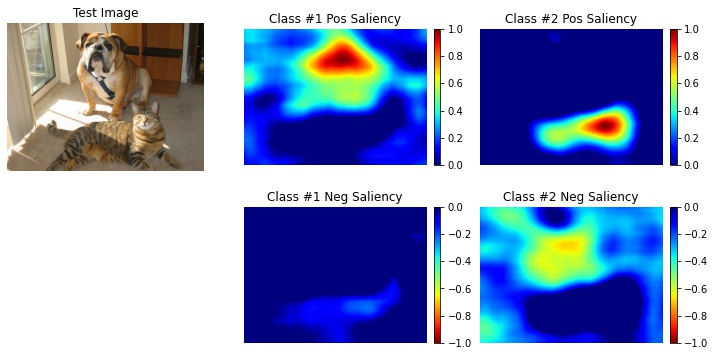

In [14]:
# Heuristic #3 -- geometric mean weighting of diff vector based on >0,  <0 "classes".
# Intuition: when there are ask regions that contribute to rare  changes in  prediction result,
# they must be relatively more important to that prediction.
from scipy.stats import gmean

# shape [diff.shape[1] x 2], columns correspond to columns of diff.
pos_neg_counts = np.vstack([
    (diff > 0).sum(axis=0),
    (diff < 0).sum(axis=0),
])
print(f"Pos/neg counts (class column-major):\n{pos_neg_counts}")
pos_neg_gmean = gmean(pos_neg_counts, axis=0)
print(f"Pos/Neg gmean:\n{pos_neg_gmean}")
diff_weights = pos_neg_gmean / pos_neg_counts
print(f"gmean weights for diff:\n{diff_weights}")

# Want to multiply diff weights to the appropriate columns and values based on pos/neg class.
# Result is the same shape as `diff` with deltas weighted by gmean of pos/neg skew.
diff_new = (diff  * (diff > 0) * diff_weights[0]) + (diff  * (diff < 0) * diff_weights[1])

# Compute heatmap like above reference
print("Before ranges:")
[print(f"\t[{i}] {hm_.min()} :: {hm_.max()}") for i, hm_ in enumerate(hm)]
hm_h3 = (masks_inv.T[..., None] * diff_new).sum(axis=2).T
print(F"HM-h3 ranges:")
[print(f"\t[{i}] {hm_.min()} :: {hm_.max()}") for i, hm_ in enumerate(hm_h3)]

# Normalize to mitigate gridding
masks_sum = masks_inv.sum(axis=0)
masks_sum[masks_sum == 0] = 1
hm_h3_norm = hm_h3 / masks_sum

hm_h3_scaled = maxabs_scale(
    hm_h3_norm.reshape(hm_h3.shape[0], -1),
    axis=1
).reshape(hm_h3.shape)
print("scaled ranges:")
[print(f"\t{hm_.min()} -- {hm_.max()}") for hm_ in hm_h3_scaled]

plot_saliency_maps(ref_image, hm_h3_scaled, alpha_blend=False)

# CONCLUSION: seems pretty good and intuitively accurate to me...
# Seems to also follow the evidence. E.g. class #1 has a lot positive delta examples
# and very few negative delta examples, which is shown in the response of the heatmap.

# Test H#3 on other images

In [43]:
boxer_extra_image_fp_list = [
    "more_images/boxer/210125-boxer-heart-disease-lg2.jpg",
    "more_images/boxer/Boxer Banner.jpg",
    "more_images/boxer/Boxer-care.jpg",
    "more_images/boxer/Boxer-dogs-keep-each-other-company.jpg",
    "more_images/boxer/senior-boxer-dog-puppy-260nw-1803834613.webp",
]

In [44]:
for img_fp in boxer_extra_image_fp_list:
    print(f"### IMAGE :: {img_fp} ###")
    # For consistency of sliding window application
    ref_image = np.asarray(PIL.Image.open(img_fp).resize((640,480)))
    print(blackbox_topk(ref_image))

### IMAGE :: more_images/boxer/210125-boxer-heart-disease-lg2.jpg ###
boxer
### IMAGE :: more_images/boxer/Boxer Banner.jpg ###
boxer
### IMAGE :: more_images/boxer/Boxer-care.jpg ###
boxer
### IMAGE :: more_images/boxer/Boxer-dogs-keep-each-other-company.jpg ###
boxer
### IMAGE :: more_images/boxer/senior-boxer-dog-puppy-260nw-1803834613.webp ###
boxer


In [45]:
tigercat_extra_image_fp_list = [
    "more_images/tiger_cat/Screen-Shot-2018-12-04-at-10.45.44-AM.webp",
    "more_images/tiger_cat/Tiger-cat-full.jpg",
    "more_images/tiger_cat/vertical-shot-of-a-toyger-cat-reflected-in-the-water-as-a-tiger-concept-of-inner-strength-163720110.jpg",
]

In [46]:
for img_fp in tigercat_extra_image_fp_list:
    print(f"### IMAGE :: {img_fp} ###")
    # For consistency of sliding window application
    ref_image = np.asarray(PIL.Image.open(img_fp).resize((640,480)))
    print(blackbox_topk(ref_image))

### IMAGE :: more_images/tiger_cat/Screen-Shot-2018-12-04-at-10.45.44-AM.webp ###
tiger cat
### IMAGE :: more_images/tiger_cat/Tiger-cat-full.jpg ###
tiger cat
### IMAGE :: more_images/tiger_cat/vertical-shot-of-a-toyger-cat-reflected-in-the-water-as-a-tiger-concept-of-inner-strength-163720110.jpg ###
tiger cat


In [52]:
from scipy.stats import gmean
from sklearn.preprocessing import maxabs_scale
from typing import Callable, Optional, Sequence, Union
from xaitk_saliency import PerturbImage
from xaitk_saliency.utils.masking import occlude_image_streaming


def h3_method(
    ref_image: PIL.Image.Image,
    # Assuming outputs `nClass` length arrays.
    blackbox_classify: Callable[[PIL.Image.Image], np.ndarray],
    perturber: PerturbImage,
    fill: Optional[Union[int, Sequence[int]]] = None,
):
    """ Like app but with OcclusionScoring manually broken out with heuristic 3. """
    # Use the perterbation API implementation input to generate a bunch of images.
    # We will use the outputs here multiple times later so we will just aggregate
    # the output here.
    pert_masks = perturber(ref_image)
    print(f"Perterbation masks: {pert_masks.shape}")
    
    pert_imgs = occlude_image_streaming(ref_image, pert_masks, fill, threads=8)

    # For the saliency heatmap generation API we need reference image predictions as well as
    # the predictions for each of the perturbed images.
    ref_preds = blackbox_classify(ref_image)
    print(f"Ref preds: {ref_preds.shape}")
    pert_preds = np.asarray([
        blackbox_classify(pi)
        for pi in pert_imgs
    ])

    print(f"Pert preds: {pert_preds.shape}")
    ### MANUAL WITH HEURISTIC 3
    diff = ref_preds - pert_preds
    print("Diffs ranges (mins, maxs)")
    print(diff.min(axis=0))
    print(diff.max(axis=0))
    # shape [diff.shape[1] x 2], columns correspond to columns of diff.
    pos_neg_counts = np.vstack([
        (diff > 0).sum(axis=0),
        (diff < 0).sum(axis=0),
    ])
    print(f"Pos/neg counts (class column-major):\n{pos_neg_counts}")
    pos_neg_gmean = gmean(pos_neg_counts, axis=0)
    print(f"Pos/Neg gmean:\n{pos_neg_gmean}")
    diff_weights = pos_neg_gmean / pos_neg_counts
    print(f"gmean weights for diff:\n{diff_weights}")
    # Want to multiply diff weights to the appropriate columns and values based on pos/neg class.
    # Result is the same shape as `diff` with deltas weighted by gmean of pos/neg skew.
    diff_new = (diff  * (diff > 0) * diff_weights[0]) + (diff  * (diff < 0) * diff_weights[1])
    # Compute heatmap like above reference
    masks_inv = (np.uint8(1) - pert_masks)
    hm_h3 = (masks_inv.T[..., None] * diff_new).sum(axis=2).T
    # Normalize to mitigate gridding
    masks_sum = masks_inv.sum(axis=0)
    masks_sum[masks_sum == 0] = 1
    hm_h3_norm = hm_h3 / masks_sum
    hm_h3_scaled = maxabs_scale(
        hm_h3_norm.reshape(hm_h3.shape[0], -1),
        axis=1
    ).reshape(hm_h3.shape)
    sal_maps = hm_h3_scaled
    ###
    print(f"Saliency maps: {sal_maps.shape}")
    
    # Visualize the saliency heat-maps
    plot_saliency_maps(ref_image, sal_maps, alpha_blend=True)
        
    return pert_masks, ref_preds, pert_preds, sal_maps

### IMAGE :: more_images/boxer/210125-boxer-heart-disease-lg2.jpg ###
Perterbation masks: (884, 480, 640)
Ref preds: (2,)
Pert preds: (884, 2)
Diffs ranges (mins, maxs)
[-9.4077647e-02 -3.2949157e-07]
[3.909665e-01 7.345891e-08]
Pos/neg counts (class column-major):
[[530 505]
 [354 379]]
Pos/Neg gmean:
[433.15124379 437.48714267]
gmean weights for diff:
[[0.8172665  0.86631117]
 [1.22359108 1.15431964]]
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-0.336200200393692, 1.0]
Class 1 saliency map range: [-1.0, 0.22018644208864593]
### IMAGE :: more_images/boxer/Boxer Banner.jpg ###
Perterbation masks: (884, 480, 640)
Ref preds: (2,)
Pert preds: (884, 2)
Diffs ranges (mins, maxs)
[-0.04848421 -0.00010827]
[7.0057434e-01 2.6670532e-06]
Pos/neg counts (class column-major):
[[615 314]
 [269 570]]
Pos/Neg gmean:
[406.73701577 423.06027939]
gmean weights for diff:
[[0.661361   1.34732573]
 [1.51203352 0.74221102]]
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-0.17409474

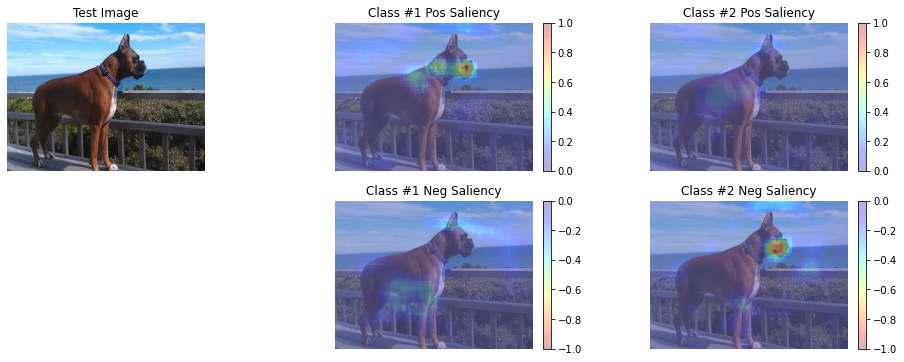

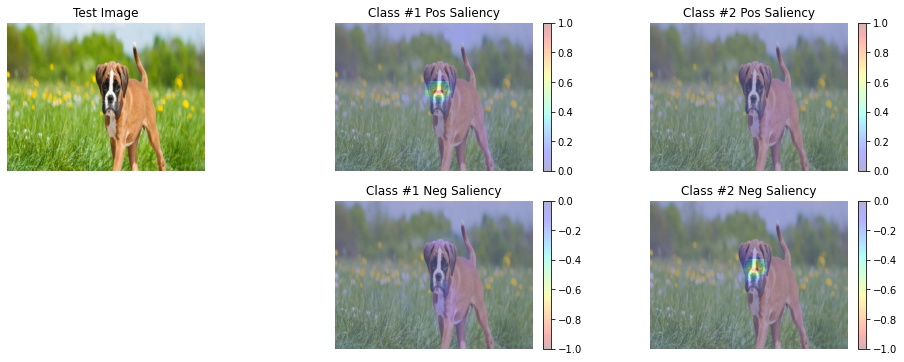

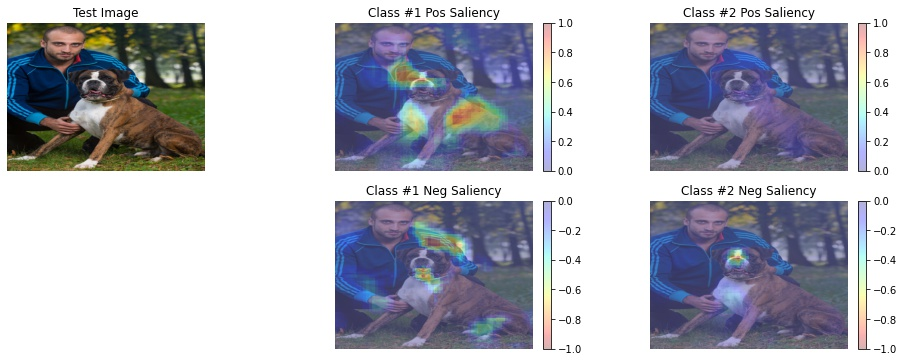

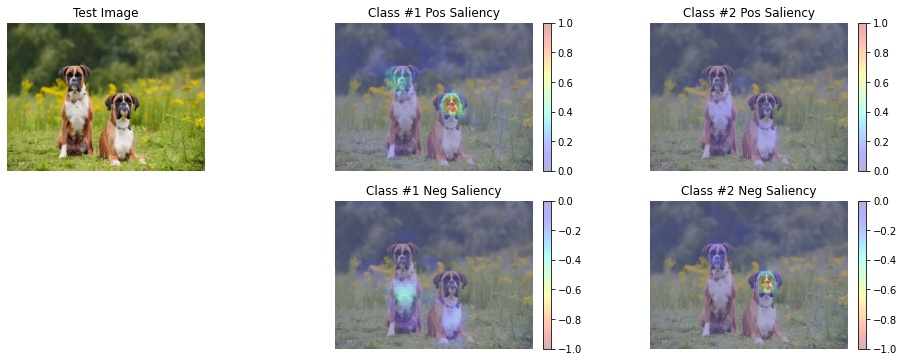

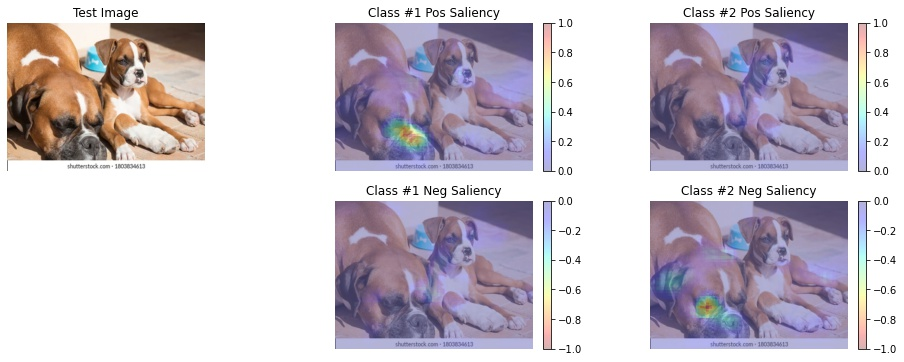

In [54]:
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindowPerturb

perturber = SlidingWindowPerturb((50, 50), (20, 20))

for img_fp in boxer_extra_image_fp_list:
    print(f"### IMAGE :: {img_fp} ###")
    # For consistency of sliding window application
    ref_image = np.asarray(PIL.Image.open(img_fp).resize((640,480)))
    h3_method(ref_image, blackbox_classifier, perturber, fill=blackbox_fill)

### IMAGE :: more_images/tiger_cat/Screen-Shot-2018-12-04-at-10.45.44-AM.webp ###
Perterbation masks: (884, 480, 640)
Ref preds: (2,)
Pert preds: (884, 2)
Diffs ranges (mins, maxs)
[-1.3679136e-06 -1.1331181e-01]
[1.5313168e-07 1.0799208e-01]
Pos/neg counts (class column-major):
[[518 387]
 [366 497]]
Pos/Neg gmean:
[435.41704147 438.56470446]
gmean weights for diff:
[[0.84057344 1.13324213]
 [1.18966405 0.88242395]]
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-1.0, 0.08946949517093311]
Class 1 saliency map range: [-0.7424218810597608, 1.0]
### IMAGE :: more_images/tiger_cat/Tiger-cat-full.jpg ###
Perterbation masks: (884, 480, 640)
Ref preds: (2,)
Pert preds: (884, 2)
Diffs ranges (mins, maxs)
[-1.7043433e-06 -1.2655622e-01]
[5.0204636e-07 2.0139301e-01]
Pos/neg counts (class column-major):
[[594 600]
 [290 284]]
Pos/Neg gmean:
[415.04216653 412.79534881]
gmean weights for diff:
[[0.69872419 0.68799225]
 [1.43117988 1.45350475]]
Saliency maps: (2, 480, 640)
Class 0 salie

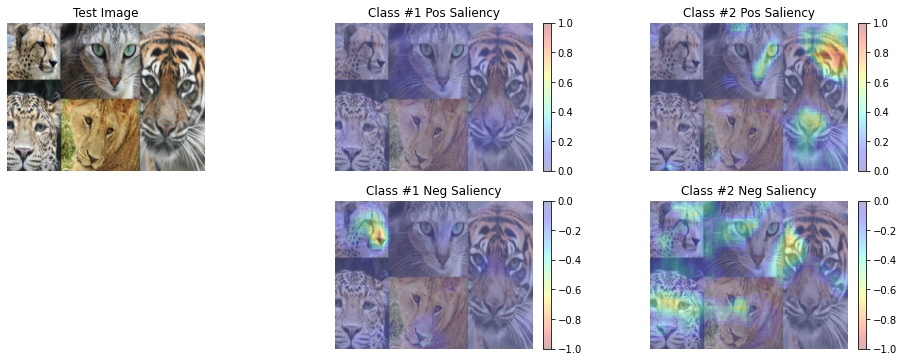

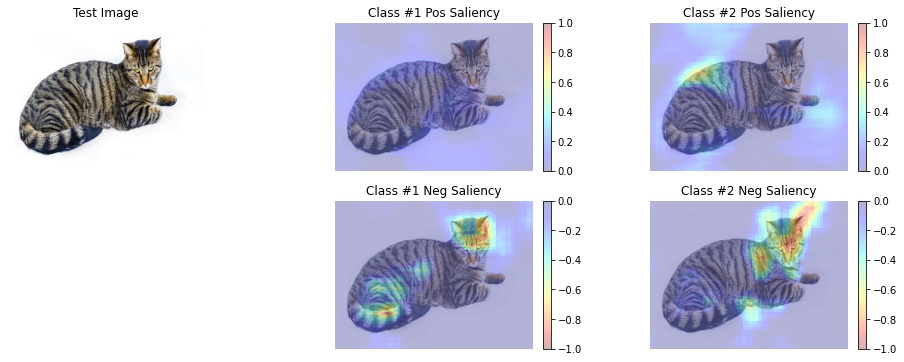

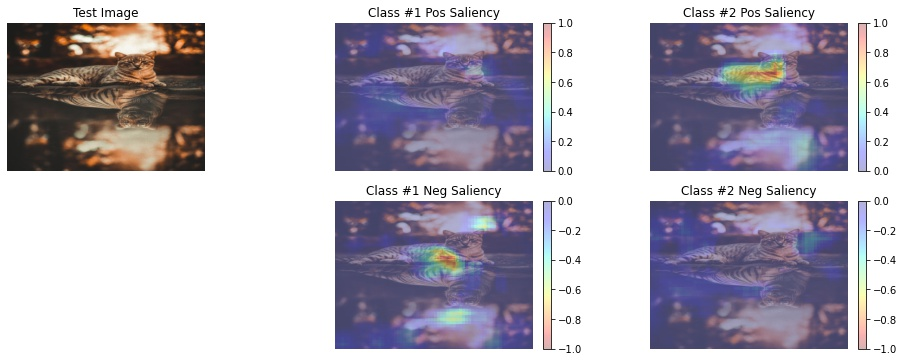

In [53]:
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindowPerturb

perturber = SlidingWindowPerturb((50, 50), (20, 20))

for img_fp in tigercat_extra_image_fp_list:
    print(f"### IMAGE :: {img_fp} ###")
    # For consistency of sliding window application
    ref_image = np.asarray(PIL.Image.open(img_fp).resize((640,480)))
    h3_method(ref_image, blackbox_classifier, perturber, fill=blackbox_fill)

### IMAGE :: more_images/boxer/210125-boxer-heart-disease-lg2.jpg ###
Perterbation masks: (1833, 480, 640)
Ref preds: (2,)
Pert preds: (1833, 2)
Diffs ranges (mins, maxs)
[-0.13052124 -0.00037543]
[8.179717e-01 7.936593e-08]
Pos/neg counts (class column-major):
[[1210  493]
 [ 623 1340]]
Pos/Neg gmean:
[868.23383947 812.78533451]
gmean weights for diff:
[[0.71754863 1.64865179]
 [1.39363377 0.60655622]]
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-0.10101361992909375, 1.0]
Class 1 saliency map range: [-1.0, -2.819209694709579e-05]
### IMAGE :: more_images/boxer/Boxer Banner.jpg ###
Perterbation masks: (1833, 480, 640)
Ref preds: (2,)
Pert preds: (1833, 2)
Diffs ranges (mins, maxs)
[-0.05526918 -0.01597407]
[9.2327344e-01 2.0832990e-06]
Pos/neg counts (class column-major):
[[1576  425]
 [ 257 1408]]
Pos/Neg gmean:
[636.42124415 773.56318423]
gmean weights for diff:
[[0.40382059 1.82014867]
 [2.47634725 0.54940567]]
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [

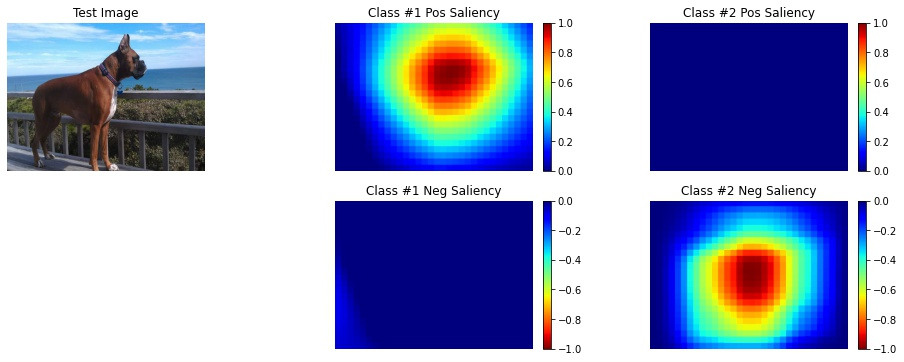

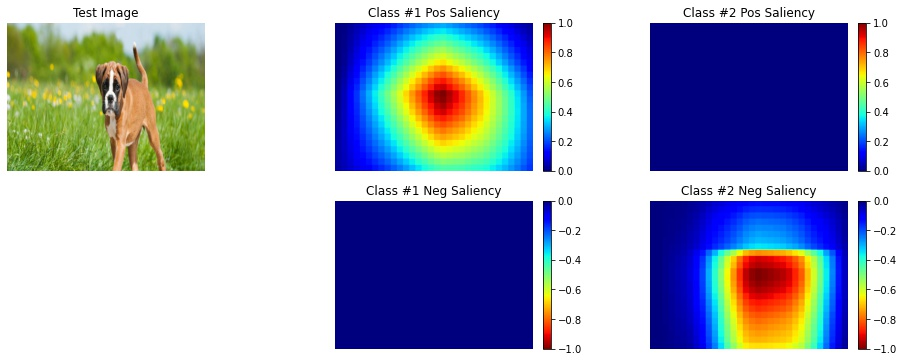

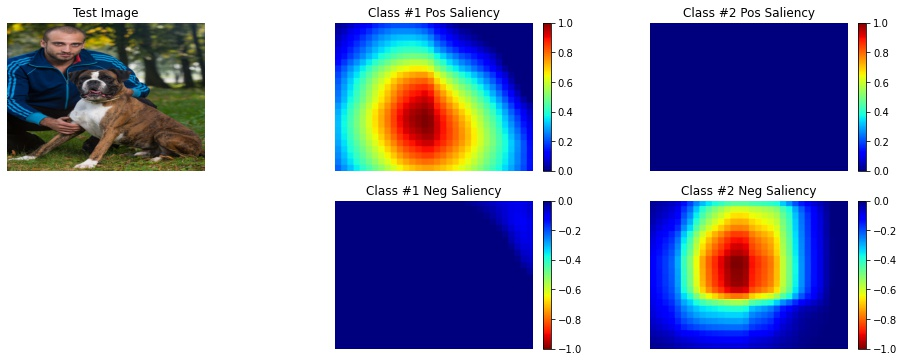

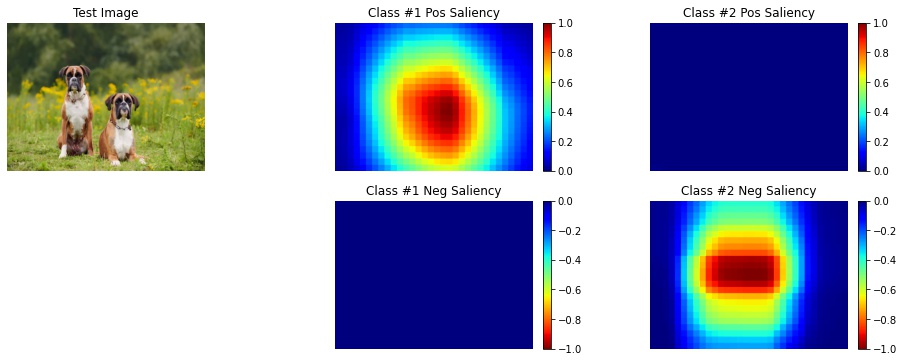

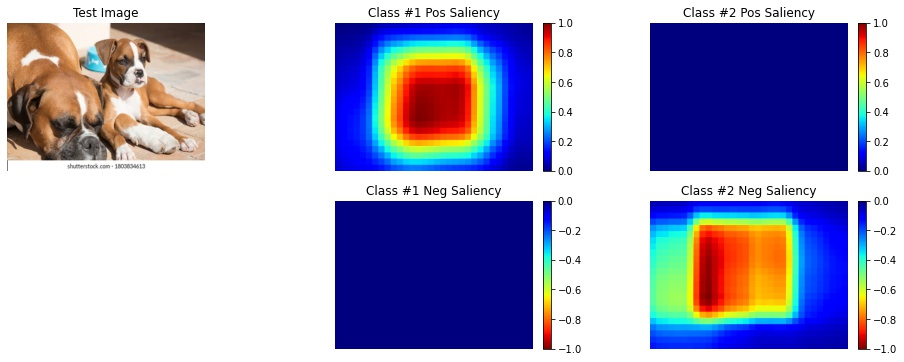

In [49]:
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindowPerturb

perturber = SlidingWindowPerturb((320, 320), (20, 20))

for img_fp in boxer_extra_image_fp_list:
    print(f"### IMAGE :: {img_fp} ###")
    # For consistency of sliding window application
    ref_image = np.asarray(PIL.Image.open(img_fp).resize((640,480)))
    h3_method(ref_image, blackbox_classifier, perturber, fill=blackbox_fill)

### IMAGE :: more_images/tiger_cat/Screen-Shot-2018-12-04-at-10.45.44-AM.webp ###
Perterbation masks: (1833, 480, 640)
Ref preds: (2,)
Pert preds: (1833, 2)
Diffs ranges (mins, maxs)
[-6.054449e-06 -4.204483e-01]
[2.5269907e-07 2.4654615e-01]
Pos/neg counts (class column-major):
[[ 827  964]
 [1006  869]]
Pos/Neg gmean:
[912.11950971 915.26826668]
gmean weights for diff:
[[1.10292565 0.94944841]
 [0.90667943 1.05324311]]
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-1.0, 0.2255878486405015]
Class 1 saliency map range: [-1.0, 0.6977214465478139]
### IMAGE :: more_images/tiger_cat/Tiger-cat-full.jpg ###
Perterbation masks: (1833, 480, 640)
Ref preds: (2,)
Pert preds: (1833, 2)
Diffs ranges (mins, maxs)
[-1.2634741e-04 -1.7844677e-01]
[5.8395017e-07 5.1423711e-01]
Pos/neg counts (class column-major):
[[1094 1389]
 [ 739  444]]
Pos/Neg gmean:
[899.1473739  785.31267658]
gmean weights for diff:
[[0.82188974 0.5653799 ]
 [1.21670822 1.76872224]]
Saliency maps: (2, 480, 640)
Clas

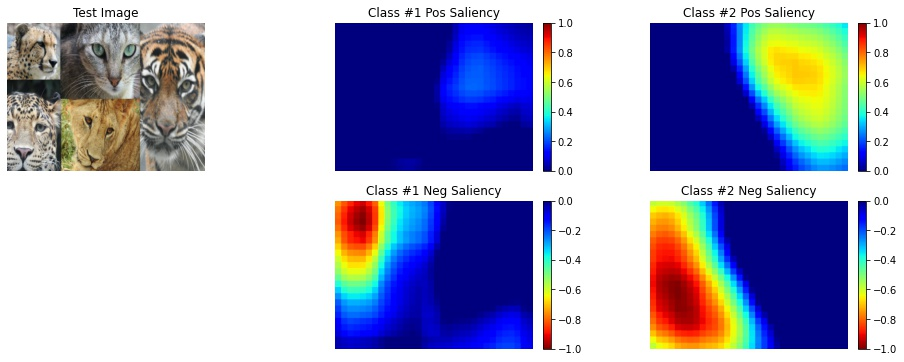

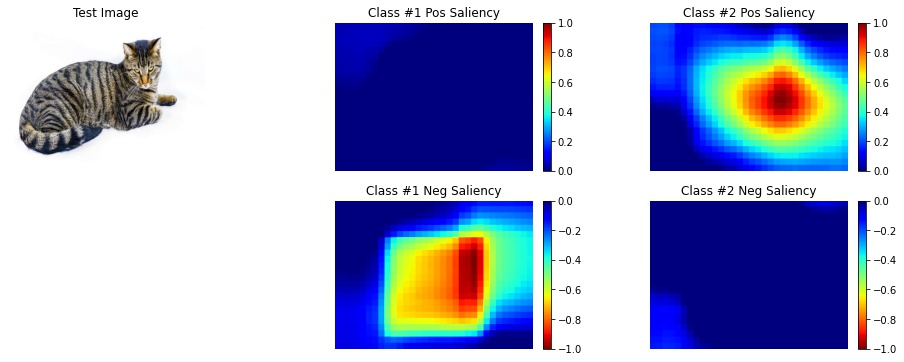

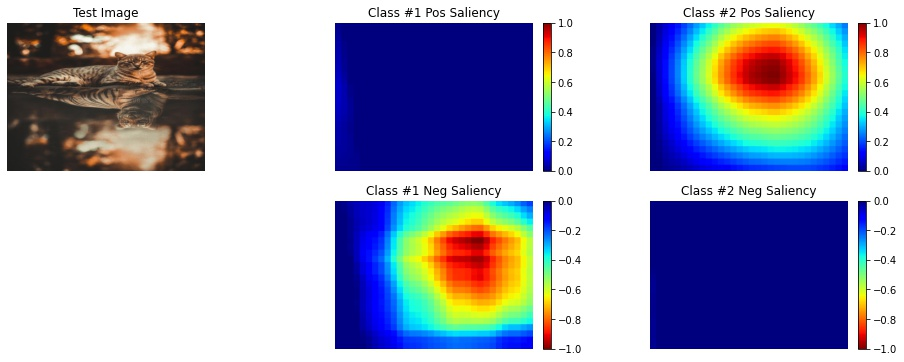

In [47]:
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindowPerturb

perturber = SlidingWindowPerturb((320, 320), (20, 20))

for img_fp in tigercat_extra_image_fp_list:
    print(f"### IMAGE :: {img_fp} ###")
    # For consistency of sliding window application
    ref_image = np.asarray(PIL.Image.open(img_fp).resize((640,480)))
    h3_method(ref_image, blackbox_classifier, perturber, fill=blackbox_fill)

### IMAGE :: more_images/boxer/210125-boxer-heart-disease-lg2.jpg ###
Perterbation masks: (1000, 480, 640)
Ref preds: (2,)
Pert preds: (1000, 2)
Diffs ranges (mins, maxs)
[-0.13706648 -0.00328188]
[8.179663e-01 7.994702e-08]
Pos/neg counts (class column-major):
[[985  13]
 [ 15 987]]
Pos/Neg gmean:
[121.55245781 113.27400408]
gmean weights for diff:
[[0.12340351 8.71338493]
 [8.10349719 0.11476596]]
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [0.6763122715258019, 1.0]
Class 1 saliency map range: [-1.0, -0.5242973045907512]
### IMAGE :: more_images/boxer/Boxer Banner.jpg ###
Perterbation masks: (1000, 480, 640)
Ref preds: (2,)
Pert preds: (1000, 2)
Diffs ranges (mins, maxs)
[-0.04376036 -0.09961448]
[9.2333388e-01 1.8450944e-06]
Pos/neg counts (class column-major):
[[985  21]
 [ 15 979]]
Pos/Neg gmean:
[121.55245781 143.38409954]
gmean weights for diff:
[[0.12340351 6.82781426]
 [8.10349719 0.14645975]]
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [0.73188562521

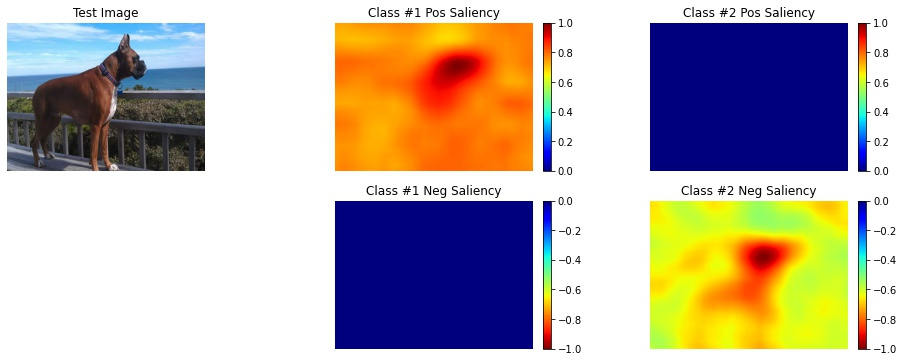

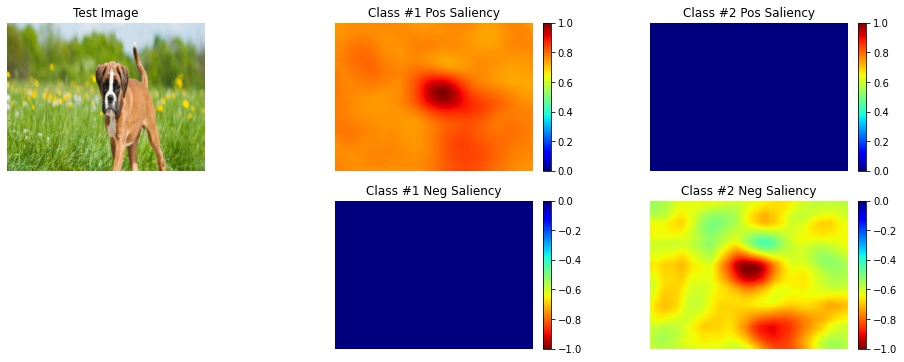

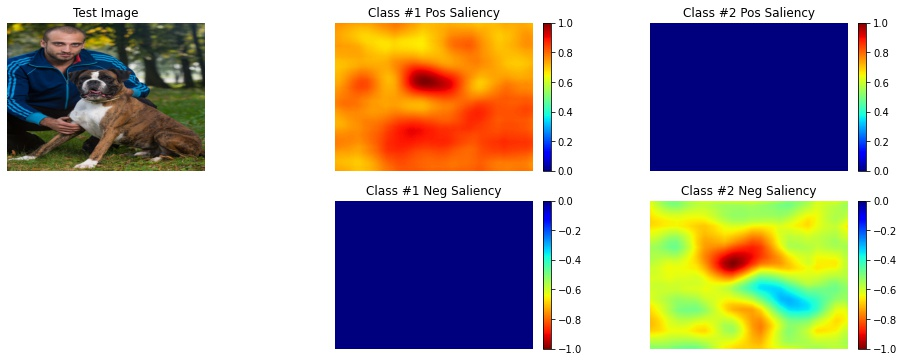

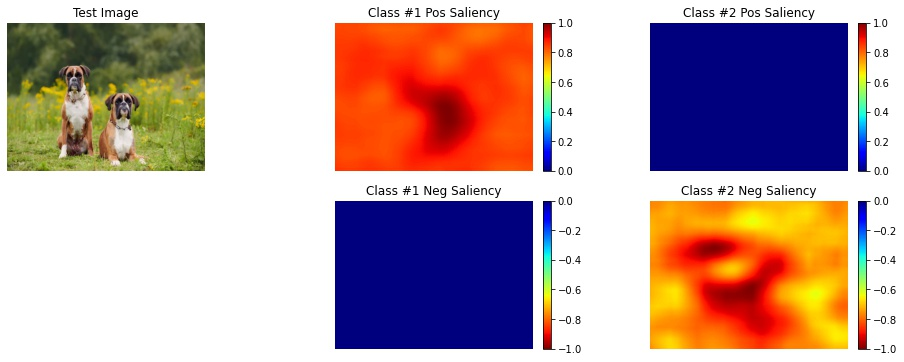

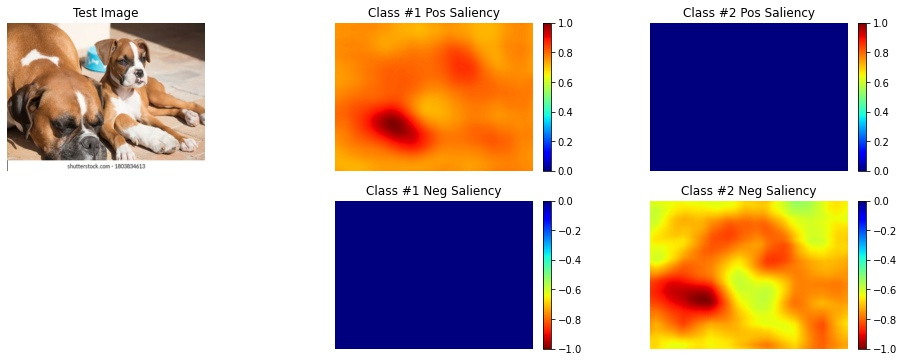

In [19]:
from xaitk_saliency.impls.perturb_image.rise import RISEPertubation

perturber = RISEPertubation(1000, 8, 0.5, seed=0, threads=4)

for img_fp in boxer_extra_image_fp_list:
    print(f"### IMAGE :: {img_fp} ###")
    # For consistency of sliding window application
    ref_image = np.asarray(PIL.Image.open(img_fp).resize((640,480)))
    h3_method(ref_image, blackbox_classifier, perturber, fill=blackbox_fill)

### IMAGE :: more_images/tiger_cat/Screen-Shot-2018-12-04-at-10.45.44-AM.webp ###
Perterbation masks: (1000, 480, 640)
Ref preds: (2,)
Pert preds: (1000, 2)
Diffs ranges (mins, maxs)
[-2.9602084e-05 -5.9246415e-01]
[2.5299730e-07 2.4525662e-01]
Pos/neg counts (class column-major):
[[699 603]
 [301 397]]
Pos/Neg gmean:
[458.69270759 489.27599573]
gmean weights for diff:
[[0.65621274 0.81140298]
 [1.52389604 1.23243324]]
Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-1.0, -0.3224951118477821]
Class 1 saliency map range: [-1.0, 0.7506114761867705]
### IMAGE :: more_images/tiger_cat/Tiger-cat-full.jpg ###
Perterbation masks: (1000, 480, 640)
Ref preds: (2,)
Pert preds: (1000, 2)
Diffs ranges (mins, maxs)
[-1.6016448e-04 -3.2617939e-01]
[5.7272013e-07 5.0487936e-01]
Pos/neg counts (class column-major):
[[200 661]
 [800 339]]
Pos/Neg gmean:
[400.         473.36983427]
gmean weights for diff:
[[2.         0.71614196]
 [0.5        1.39637119]]
Saliency maps: (2, 480, 640)
Class 0 s

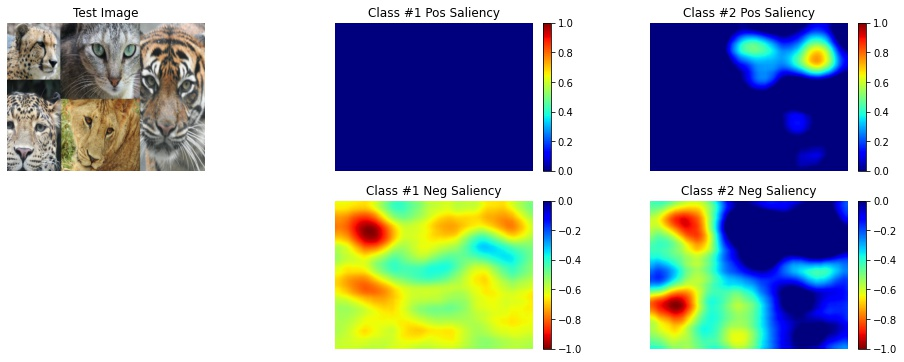

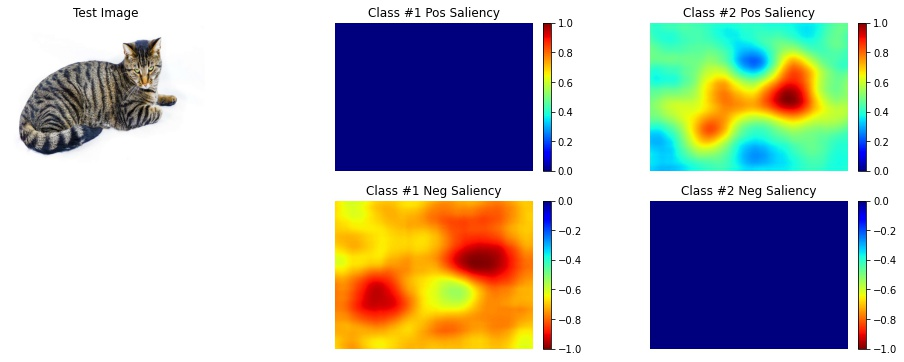

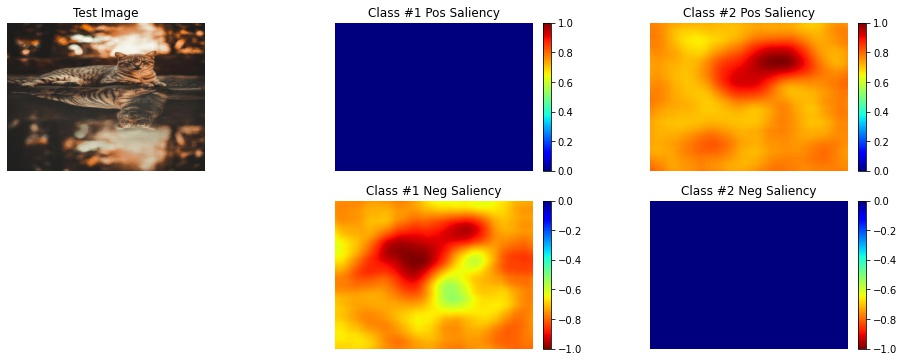

In [48]:
from xaitk_saliency.impls.perturb_image.rise import RISEPertubation

perturber = RISEPertubation(1000, 8, 0.5, seed=0, threads=4)

for img_fp in tigercat_extra_image_fp_list:
    print(f"### IMAGE :: {img_fp} ###")
    # For consistency of sliding window application
    ref_image = np.asarray(PIL.Image.open(img_fp).resize((640,480)))
    h3_method(ref_image, blackbox_classifier, perturber, fill=blackbox_fill)